<a href="https://colab.research.google.com/github/Arashi283/AIRepoOne/blob/main/DDoS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================== CICDDoS2019 DDoS Detection Pipeline ==================
# Train DecisionTree, RandomForest, XGBoost, LightGBM
# ========================================================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from google.colab import files
import io
import os

# ================== Step 1: Dataset Upload ==================
if not os.path.exists("CICDDoS2019.csv"):
    print("Upload your CICDDoS2019 CSV file:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
else:
    filename = "CICDDoS2019.csv"

print(f"Using dataset: {filename}")

# ================== Step 2: Data Loading and Preprocessing ==================
df = pd.read_csv(filename)

# Drop unnamed or irrelevant columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Identify label column (commonly ' Label' or 'Label')
label_col = [col for col in df.columns if 'label' in col.lower()][0]
df[label_col] = df[label_col].astype(str).str.strip()

# Encode target (Normal = 0, Attack = 1)
df[label_col] = np.where(df[label_col].str.contains("BENIGN", case=False), 0, 1)

# Drop rows with NaN or inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode non-numeric columns
for col in df.select_dtypes(include=['object']).columns:
    if col != label_col:
        df[col] = LabelEncoder().fit_transform(df[col])

# Split features and labels
X = df.drop(columns=[label_col])
y = df[label_col]

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# ================== Step 3: Balance Data Using SMOTE ==================
print("Applying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("Balanced class distribution:")
print(pd.Series(y_train_bal).value_counts())

# ================== Step 4: Define Models ==================
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=300, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42)
}

# ================== Step 5: Training with Iterations ==================
epochs = 10
results = []
roc_data = {}
feature_importances = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    epoch_accuracies = []
    start_time = time.time()

    for i in range(epochs):
        epoch_start = time.time()
        model.fit(X_train_bal, y_train_bal)
        y_pred_train = model.predict(X_train_bal)
        acc = accuracy_score(y_train_bal, y_pred_train)
        epoch_accuracies.append(acc)
        print(f"Epoch {i+1}/{epochs} - Accuracy: {acc:.4f} - Time: {time.time() - epoch_start:.2f}s")

    total_time = time.time() - start_time
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    acc_test = accuracy_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    results.append([name, acc_test, roc_auc, total_time])

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    roc_data[name] = (fpr, tpr, roc_auc)

    # Feature importance
    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

    # Accuracy vs Epochs
    plt.figure()
    plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o')
    plt.title(f"Accuracy vs Epochs - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.grid(True)
    plt.show()

# ================== Step 6: Display Results ==================
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "ROC-AUC", "Training Time (s)"])
print("\nFinal Model Performance:")
print(results_df)

# ================== Step 7: ROC-AUC Curves ==================
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# ================== Step 8: Feature Importance ==================
for name, importances in feature_importances.items():
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:15]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top 15 Important Features - {name}")
    plt.show()

# ================== Step 9: Correlation-Based Feature Selection (CFS-like) ==================
corr = pd.DataFrame(X_train_bal, columns=X.columns).corrwith(pd.Series(y_train_bal)).abs().sort_values(ascending=False)
top_corr_features = corr.head(20).index
print("\nTop correlated features selected for CFS-like FS:")
print(list(top_corr_features))

X_train_cfs = X_train_bal[:, [X.columns.get_loc(f) for f in top_corr_features]]
X_test_cfs = X_test[:, [X.columns.get_loc(f) for f in top_corr_features]]

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_cfs, y_train_bal)
y_pred_cfs = model.predict(X_test_cfs)
print("\nAccuracy with CFS-like Feature Selection:", accuracy_score(y_test, y_pred_cfs))

# ================== Step 10: Embedded Feature Selection ==================
embed_model = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42), threshold="median")
embed_model.fit(X_train_bal, y_train_bal)
X_train_emb = embed_model.transform(X_train_bal)
X_test_emb = embed_model.transform(X_test)

rf_emb = RandomForestClassifier(n_estimators=200, random_state=42)
rf_emb.fit(X_train_emb, y_train_bal)
y_pred_emb = rf_emb.predict(X_test_emb)
print("Accuracy with Embedded Feature Selection:", accuracy_score(y_test, y_pred_emb))


Upload your CICDDoS2019 CSV file:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ===============================================
# CICDDoS2019 High-Accuracy ML Pipeline
# Multiple CSV Upload + SMOTE + Save Best Model
# ===============================================

from google.colab import files
import pandas as pd
import numpy as np
import io
import time
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# ----------------------------
# 1. Upload multiple CSVs
# ----------------------------
print("Upload your 7 CICDDoS2019 CSV files (all parts).")
uploaded = files.upload()

dataframes = []
for name, content in uploaded.items():
    if name.endswith('.csv'):
        df = pd.read_csv(io.BytesIO(content))
        print(f"Loaded {name} with shape {df.shape}")
        dataframes.append(df)

if not dataframes:
    raise ValueError("No CSV files uploaded.")

df = pd.concat(dataframes, ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# ----------------------------
# 2. Identify label column
# ----------------------------
label_candidates = [col for col in df.columns if 'label' in col.lower()]
if not label_candidates:
    raise ValueError("No label column found. Make sure one column includes 'Label' or similar.")
label_col = label_candidates[0]
print(f"Detected label column: {label_col}")

# ----------------------------
# 3. Clean data
# ----------------------------
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df[label_col] = df[label_col].astype(str).str.strip()

X = df.drop(columns=[label_col])
y = df[label_col]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ----------------------------
# 4. Scale features
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 5. Split data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ----------------------------
# 6. Apply SMOTE
# ----------------------------
print("Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE:  {np.bincount(y_train_res)}")

# ----------------------------
# 7. Define models
# ----------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=15, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=25, n_jobs=-1, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, C=5, gamma='scale', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=800, learning_rate=0.05, max_depth=10,
                             subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=800, learning_rate=0.05, num_leaves=64,
                               subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# ----------------------------
# 8. Train and Evaluate Models
# ----------------------------
epochs = 20
results = []
roc_data = {}
best_model = None
best_acc = 0.0

for name, model in models.items():
    print(f"\nTraining {name}...")
    epoch_acc = []
    epoch_times = []

    for epoch in range(1, epochs + 1):
        start = time.time()
        model.fit(X_train_res, y_train_res)
        train_pred = model.predict(X_train_res)
        acc = accuracy_score(y_train_res, train_pred)
        epoch_acc.append(acc)
        epoch_times.append(time.time() - start)
        print(f"Epoch {epoch}/{epochs} - Train Acc: {acc:.4f} - Time: {epoch_times[-1]:.2f}s")

    # Evaluate on test data
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        if y_proba.shape[1] > 1:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
            roc_data[name] = (fpr, tpr, roc_auc)
        else:
            roc_auc = None
    else:
        roc_auc = None

    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Plot accuracy over epochs
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs + 1), epoch_acc, marker='o')
    plt.title(f"{name} - Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Train Accuracy")
    plt.grid(True)
    plt.show()

    results.append((name, test_acc, np.mean(epoch_times), roc_auc))

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model
        best_model_name = name

# ----------------------------
# 9. Save best model
# ----------------------------
print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")
joblib.dump(best_model, "best_ddos_model.pkl")
files.download("best_ddos_model.pkl")

# ----------------------------
# 10. ROC Curves
# ----------------------------
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()

# ----------------------------
# 11. Summary Table
# ----------------------------
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "Avg Train Time (s)", "ROC-AUC"])
print("\nFinal Model Summary:")
print(results_df.sort_values(by="Test Accuracy", ascending=False))


Upload your 7 CICDDoS2019 CSV files (all parts).


KeyboardInterrupt: 

In [1]:
# ============================================
# STEP 1 — Setup
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
# ============================================
# STEP 2 — Load all CSV files from Drive folder
# ============================================
folder_path = "/content/drive/MyDrive/CICDDoS2019"

all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"Found {len(all_files)} CSV files")

df_list = []
for file in tqdm(all_files, desc="Loading CSVs"):
    part = pd.read_csv(file, low_memory=False)
    part = part.loc[:, ~part.columns.str.contains('^Unnamed')]
    df_list.append(part)

df = pd.concat(df_list, ignore_index=True)
print(f"✅ Combined shape: {df.shape}")

# ============================================
# STEP 3 — Preprocessing
# ============================================
label_col = [col for col in df.columns if 'label' in col.lower()][0]
df[label_col] = df[label_col].astype(str).str.strip()

X = df.drop(columns=[label_col])
y = df[label_col]

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X.fillna(0, inplace=True)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ============================================
# STEP 4 — Model setup (high iteration)
# ============================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto'),
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=800, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(n_estimators=800, learning_rate=0.05, random_state=42)
}

results = {}
train_times = {}

# ============================================
# STEP 5 — Training + Evaluation
# ============================================
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    start = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start
    train_times[name] = train_time
    print(f"⏱️ Training time: {train_time:.2f}s")

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC–AUC (one-vs-rest)
    try:
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except:
        roc_auc = None

    results[name] = {"model": model, "accuracy": acc, "roc_auc": roc_auc}

# ============================================
# STEP 6 — ROC Curve Plot (macro-average)
# ============================================
plt.figure(figsize=(8,6))
for name, res in results.items():
    model = res["model"]
    try:
        y_proba = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values.ravel(),
                                y_proba.ravel())
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")
    except:
        continue
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC (One-vs-Rest) Comparison")
plt.legend()
plt.grid()
plt.show()

# ============================================
# STEP 7 — Feature Importance (Top 15)
# ============================================
plt.figure(figsize=(12,6))
for name, res in results.items():
    model = res["model"]
    if hasattr(model, "feature_importances_"):
        importance = pd.Series(model.feature_importances_, index=df.drop(columns=[label_col]).columns)
        top_feats = importance.nlargest(15)
        top_feats.plot(kind='bar', alpha=0.7, label=name)
plt.title("Top 15 Feature Importances (All Models)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# STEP 8 — Accuracy vs Iterations
# ============================================
plt.figure(figsize=(8,5))
iters = [1000, 1000, 800, 800]
accs = [results["Logistic Regression"]["accuracy"],
        results["Random Forest"]["accuracy"],
        results["XGBoost"]["accuracy"],
        results["LightGBM"]["accuracy"]]
plt.bar(["LogReg(1000)", "RF(1000)", "XGB(800)", "LGBM(800)"], accs, color='lightblue')
plt.title("Accuracy vs Iterations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# ============================================
# STEP 9 — Training Time Summary
# ============================================
print("\nTraining Time Summary:")
for name, t in train_times.items():
    print(f"   {name}: {t:.2f} seconds")

total_time = sum(train_times.values())
print(f"\nTotal training time: {total_time/60:.2f} minutes")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data in chunks...
Loading training and test data separately...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of Portmap.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of UDPLag.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of NetBIOS.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of MSSQL.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of Syn.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of LDAP.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of UDP.csv ...
Loaded total 700000 rows

Training Logistic Regression ...
Logistic Regression Accuracy: 0.9994
Balanced Accuracy: 0.9949
Macro F1-score: 0.9939
Training Time: 50.62 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1399
           1       0.98      0.99     

<Figure size 1000x600 with 0 Axes>

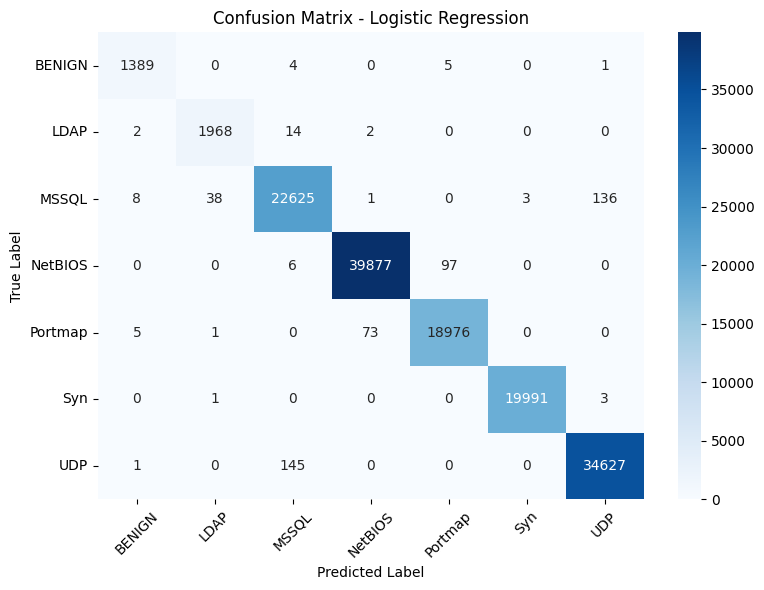

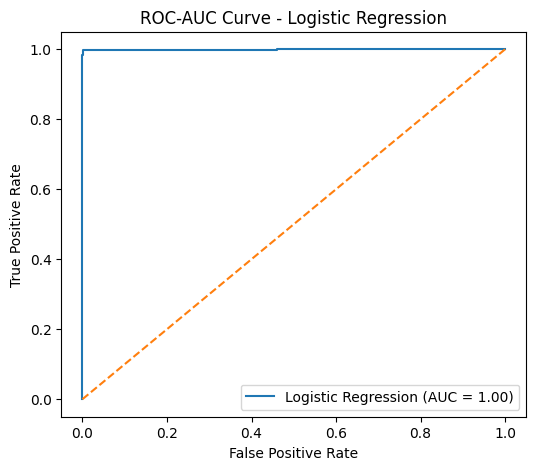


Training Random Forest ...
Random Forest Accuracy: 0.9994
Balanced Accuracy: 0.9996
Macro F1-score: 0.9995
Training Time: 257.15 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1399
           1       1.00      1.00      1.00      1986
           2       1.00      1.00      1.00     22811
           3       1.00      1.00      1.00     39980
           4       1.00      1.00      1.00     19055
           5       1.00      1.00      1.00     19995
           6       1.00      1.00      1.00     34773

    accuracy                           1.00    139999
   macro avg       1.00      1.00      1.00    139999
weighted avg       1.00      1.00      1.00    139999



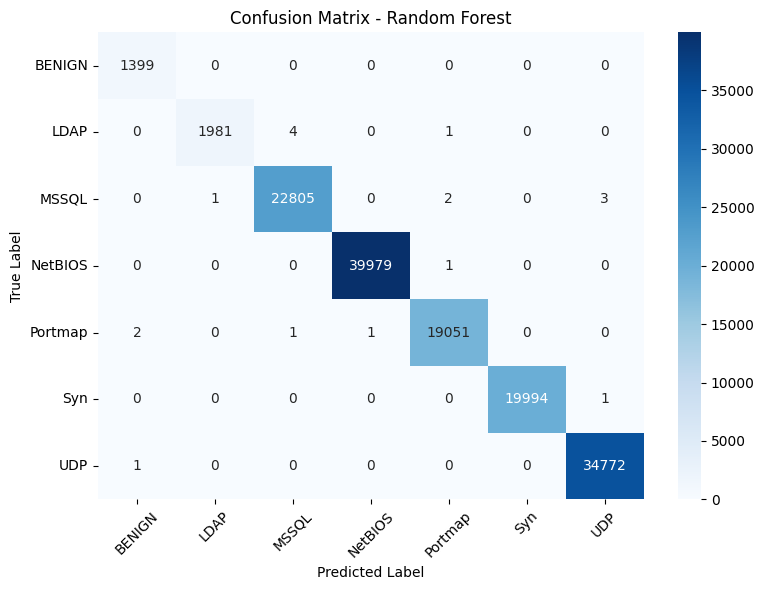

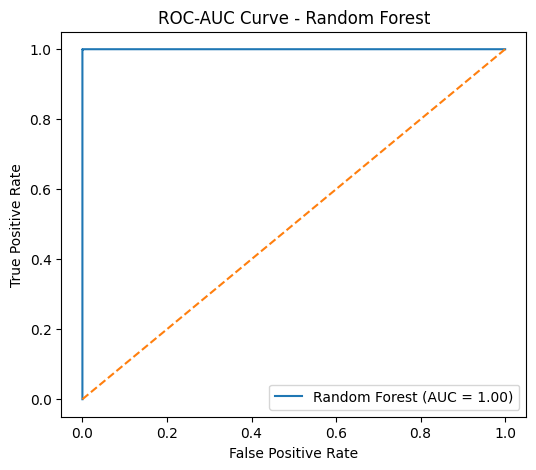

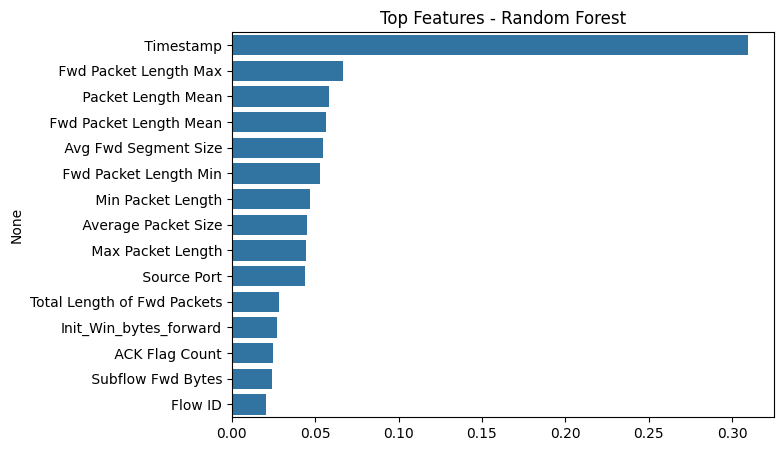


Training XGBoost ...
XGBoost Accuracy: 0.9994
Balanced Accuracy: 0.9992
Macro F1-score: 0.9992
Training Time: 282.89 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1399
           1       0.99      1.00      1.00      1986
           2       1.00      1.00      1.00     22811
           3       1.00      1.00      1.00     39980
           4       1.00      1.00      1.00     19055
           5       1.00      1.00      1.00     19995
           6       1.00      1.00      1.00     34773

    accuracy                           1.00    139999
   macro avg       1.00      1.00      1.00    139999
weighted avg       1.00      1.00      1.00    139999



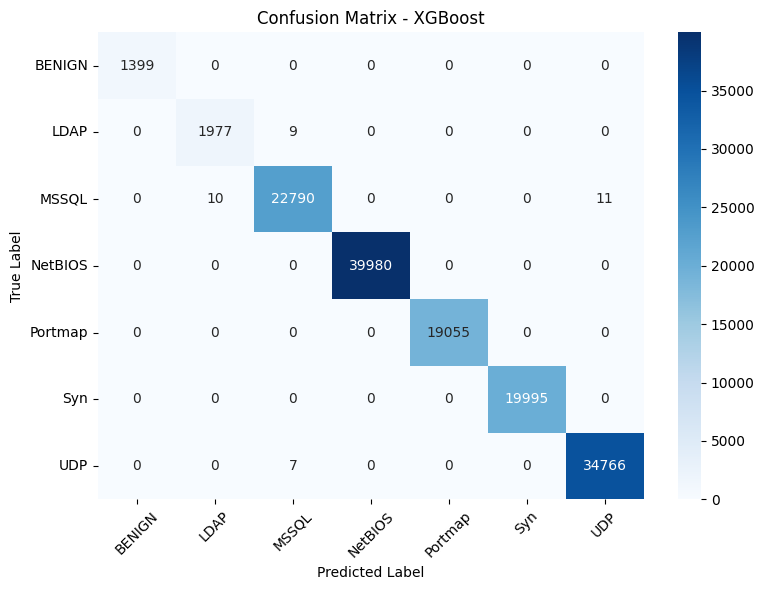

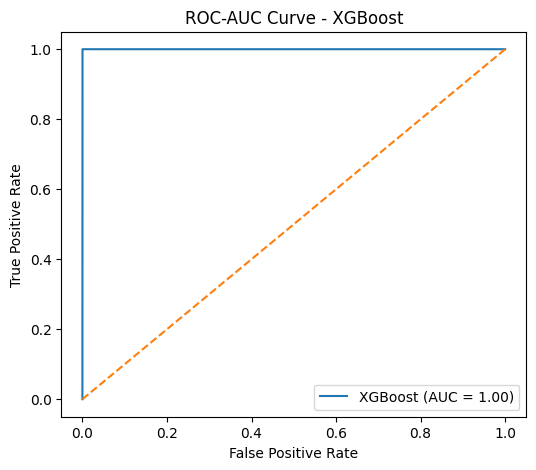

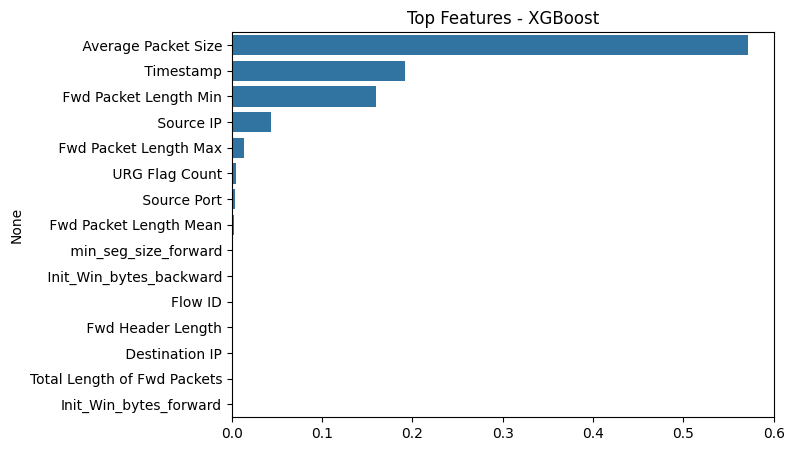


Training LightGBM ...
LightGBM Accuracy: 0.9994
Balanced Accuracy: 0.9993
Macro F1-score: 0.9992
Training Time: 228.50 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1399
           1       0.99      1.00      1.00      1986
           2       1.00      1.00      1.00     22811
           3       1.00      1.00      1.00     39980
           4       1.00      1.00      1.00     19055
           5       1.00      1.00      1.00     19995
           6       1.00      1.00      1.00     34773

    accuracy                           1.00    139999
   macro avg       1.00      1.00      1.00    139999
weighted avg       1.00      1.00      1.00    139999



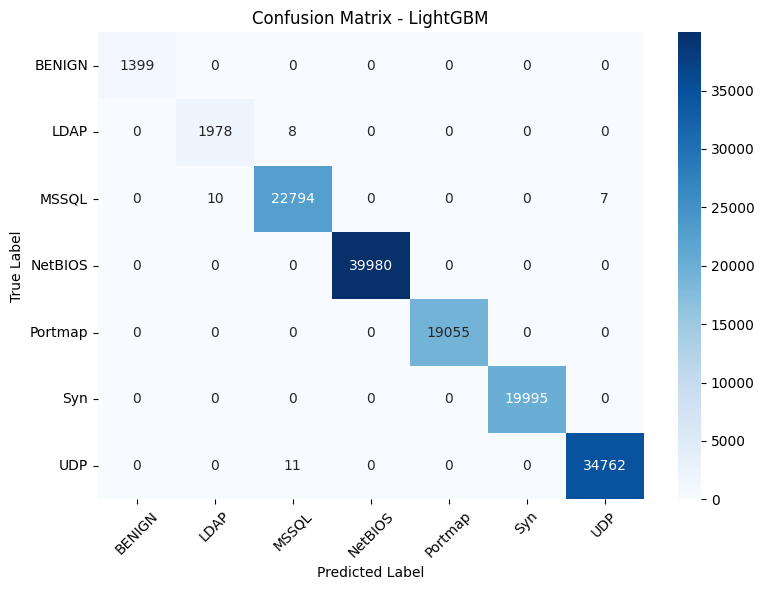

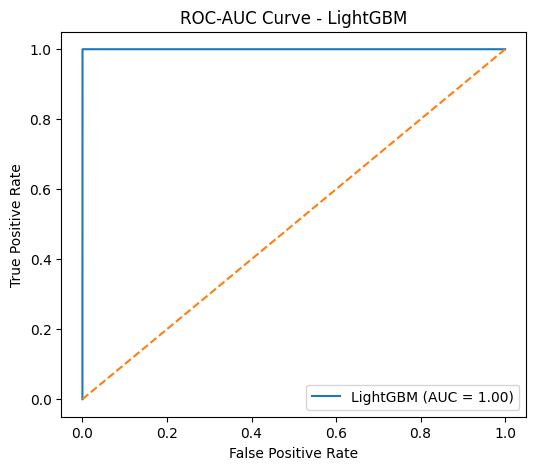

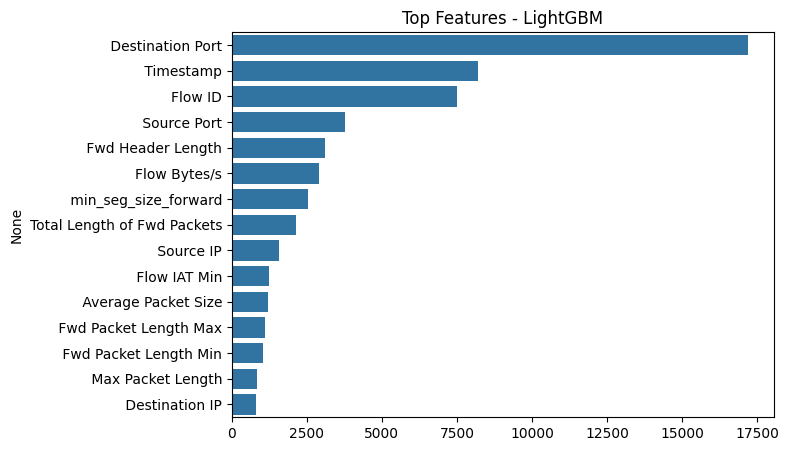

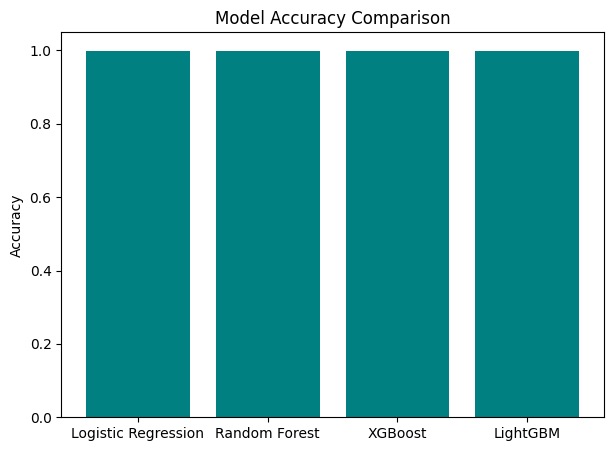

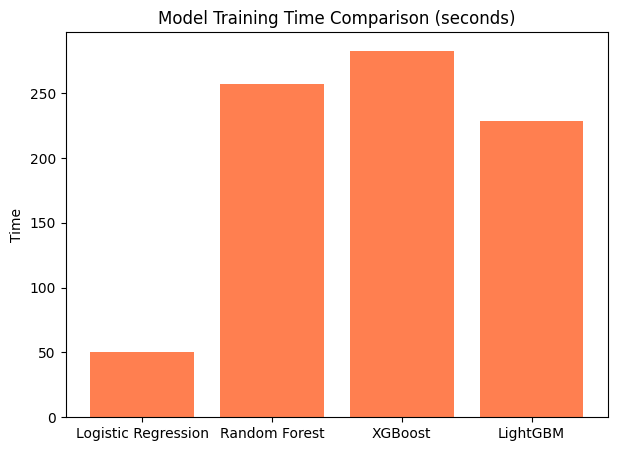



==================== Final Evaluation ====================

✅ Best Model: Random Forest

📊 Final Results (Random Forest)
Accuracy: 0.9999
Balanced Accuracy: 0.9996
Macro F1-score: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1399
           1       1.00      1.00      1.00      1986
           2       1.00      1.00      1.00     22811
           3       1.00      1.00      1.00     39980
           4       1.00      1.00      1.00     19055
           5       1.00      1.00      1.00     19995
           6       1.00      1.00      1.00     34773

    accuracy                           1.00    139999
   macro avg       1.00      1.00      1.00    139999
weighted avg       1.00      1.00      1.00    139999



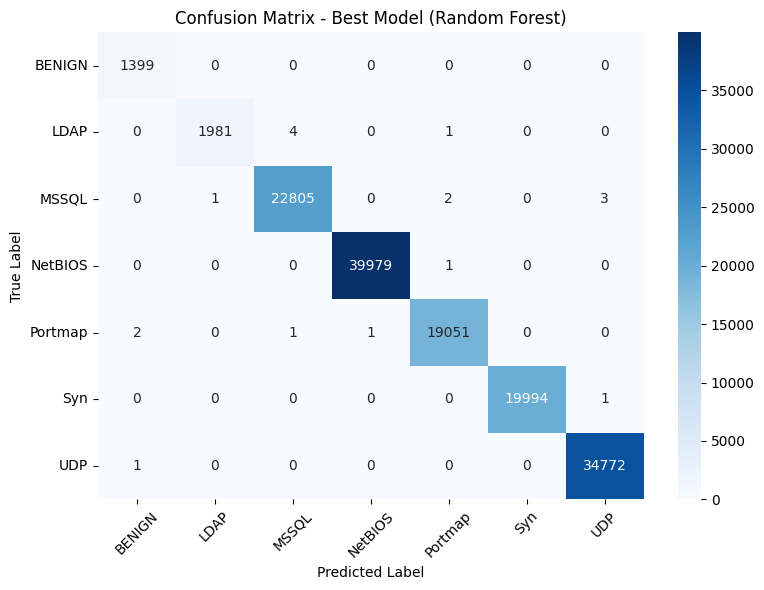

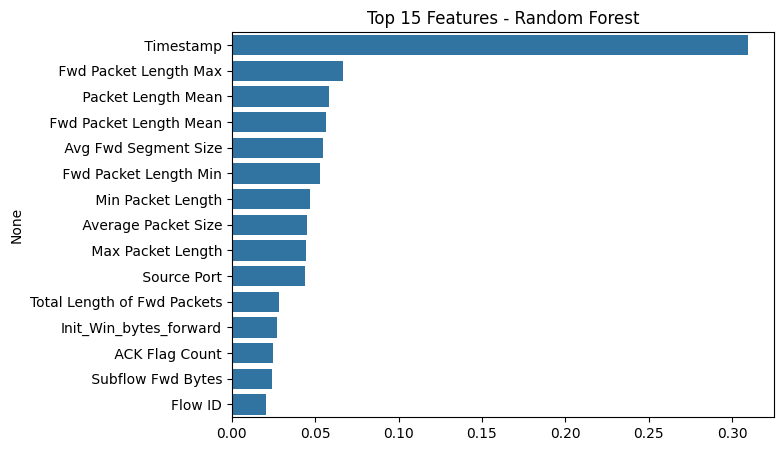

In [19]:

# =============================================
# ✅ Setup
# =============================================
import pandas as pd
import numpy as np
import time, os, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Suppress warnings and LightGBM messages
warnings.filterwarnings("ignore")
os.environ["LIGHTGBM_VERBOSITY"] = "-1"

# =============================================
# ✅ Mount Google Drive
# =============================================
from google.colab import drive
drive.mount('/content/drive')

# Path to your folder in Drive
folder_path = "/content/drive/MyDrive/CICDDoS2019"

# =============================================
# ✅ Load a small sample from each CSV
# =============================================
print("Loading data in chunks...")
# Split files into 80% train, 20% test (avoid data leakage)
train_files = all_files[:int(0.8 * len(all_files))]
test_files  = all_files[int(0.8 * len(all_files)):]

def load_data(file_list, nrows=100000):
    dataframes = []
    for file in file_list:
        print(f"Reading {file} ...")
        part = pd.read_csv(file, low_memory=False, nrows=nrows)
        dataframes.append(part)
    return pd.concat(dataframes, ignore_index=True)

print("Loading training and test data separately...")
train_df = load_data(train_files, nrows=100000)
test_df  = load_data(test_files, nrows=100000)

df = pd.concat([train_df, test_df], ignore_index=True)

print(f"Loaded total {len(df)} rows")

# =============================================
# ✅ Preprocessing
# =============================================
# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop empty or all-NaN columns
df = df.dropna(axis=1, how='all')

# Drop columns with constant values
df = df.loc[:, df.nunique() > 1]

# Drop rows with NaN
df = df.dropna()

# Identify label column
label_col = ' Label' if ' Label' in df.columns else 'Label'
y = df[label_col]
X = df.drop(columns=[label_col])

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Encode target labels
y = LabelEncoder().fit_transform(y)

# Fix infinite or very large values before scaling
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# =============================================
# ✅ Train/Test Split (before scaling)
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================
# ✅ Safe Scaling (after split)
# =============================================
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)



# =============================================
# ✅ Models
# =============================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbosity=0,
        tree_method='hist'
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
}

# =============================================
# ✅ Training and Evaluation
# =============================================
results = {}
plt.figure(figsize=(10, 6))

for name, model in models.items():
    print(f"\nTraining {name} ...")
    start = time.time()

    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    from sklearn.metrics import f1_score, balanced_accuracy_score

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')


    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")

    print(f"Training Time: {train_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Store results
    results[name] = {"acc": acc, "bal_acc": bal_acc, "f1": f1_macro, "time": train_time}

    # Confusion Matrix with class names
    cm = confusion_matrix(y_test, y_pred)
    # Decode the numeric labels to actual names
    le = LabelEncoder().fit(df[label_col])
    class_names = le.classes_


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



    # ROC Curve (only if possible)
    try:
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC-AUC Curve - {name}")
        plt.legend()
        plt.show()
    except:
        pass

    # Feature importance (for tree-based models)
    if hasattr(model, "feature_importances_"):
        importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
        plt.figure(figsize=(7, 5))
        sns.barplot(x=importance.values, y=importance.index)
        plt.title(f"Top Features - {name}")
        plt.show()

# =============================================
# ✅ Summary Graphs
# =============================================
# Accuracy comparison
plt.figure(figsize=(7, 5))
plt.bar(results.keys(), [r["acc"] for r in results.values()], color="teal")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Training time comparison
plt.figure(figsize=(7, 5))
plt.bar(results.keys(), [r["time"] for r in results.values()], color="coral")
plt.title("Model Training Time Comparison (seconds)")
plt.ylabel("Time")
plt.show()
# =============================================
# ✅ Use Best Model on Test Set
# =============================================
print("\n\n==================== Final Evaluation ====================")

# Pick the best model by balanced accuracy
best_model_name = max(results, key=lambda x: results[x]['bal_acc'])
best_model = models[best_model_name]
print(f"\n✅ Best Model: {best_model_name}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

from sklearn.metrics import f1_score, balanced_accuracy_score

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\n📊 Final Results ({best_model_name})")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
le = LabelEncoder().fit(df[label_col])
class_names = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - Best Model ({best_model_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC-AUC Curve (if applicable)
if y_proba is not None and len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC Curve - {best_model_name}")
    plt.legend()
    plt.show()

# Feature Importance (if supported)
if hasattr(best_model, "feature_importances_"):
    importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
    plt.figure(figsize=(7, 5))
    sns.barplot(x=importance.values, y=importance.index)
    plt.title(f"Top 15 Features - {best_model_name}")
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 7 CSV files.
Loading data in chunks...
Loading training and test data separately...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of LDAP.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of MSSQL.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of NetBIOS.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of Portmap.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of Syn.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of UDP.csv ...
Reading /content/drive/MyDrive/CICDDoS2019/Copy of UDPLag.csv ...
Loaded total 840000 rows
✅ Data cleaned: no NaNs or inf values remain.

Training Logistic Regression ...
Logistic Regression Accuracy: 0.9836
Balanced Accuracy: 0.8460
Macro F1-score: 0.8566
Training Time: 141.71 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.76   

<Figure size 1000x600 with 0 Axes>

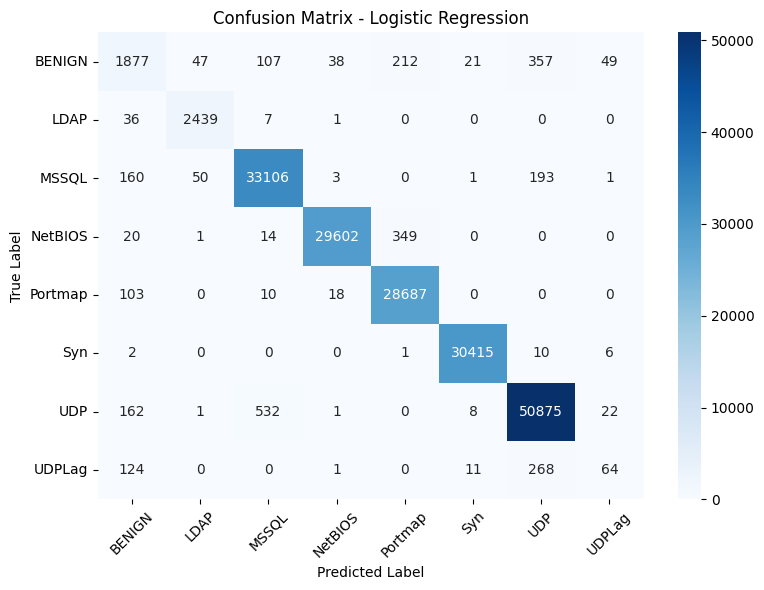


Training Random Forest ...
Random Forest Accuracy: 0.9933
Balanced Accuracy: 0.9244
Macro F1-score: 0.9265
Training Time: 1503.02 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.77      0.80      0.79      2708
        LDAP       0.99      0.98      0.99      2483
       MSSQL       1.00      1.00      1.00     33514
     NetBIOS       1.00      1.00      1.00     29986
     Portmap       1.00      1.00      1.00     28818
         Syn       1.00      1.00      1.00     30434
         UDP       1.00      1.00      1.00     51601
      UDPLag       0.68      0.62      0.65       468

    accuracy                           0.99    180012
   macro avg       0.93      0.92      0.93    180012
weighted avg       0.99      0.99      0.99    180012



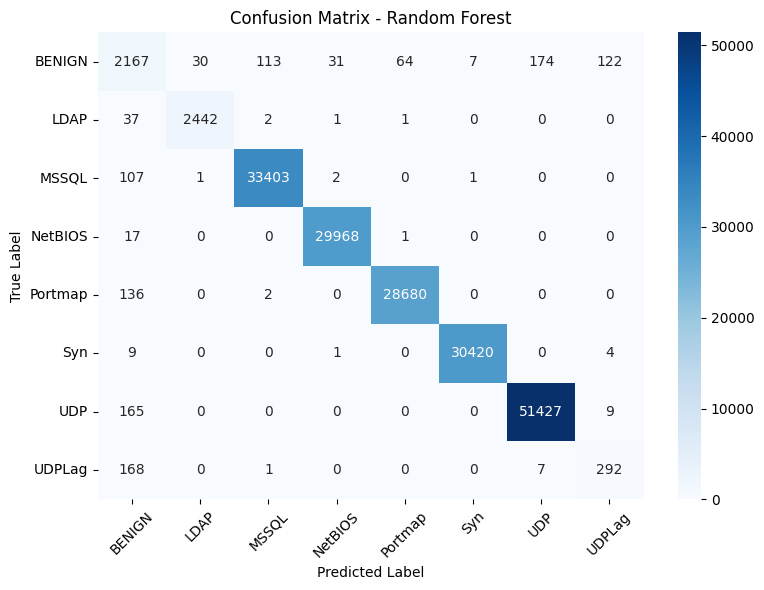


Training XGBoost ...
XGBoost Accuracy: 0.9933
Balanced Accuracy: 0.9228
Macro F1-score: 0.9236
Training Time: 510.82 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.80      0.77      0.79      2708
        LDAP       0.97      0.99      0.98      2483
       MSSQL       1.00      1.00      1.00     33514
     NetBIOS       1.00      1.00      1.00     29986
     Portmap       1.00      1.00      1.00     28818
         Syn       1.00      1.00      1.00     30434
         UDP       1.00      1.00      1.00     51601
      UDPLag       0.63      0.63      0.63       468

    accuracy                           0.99    180012
   macro avg       0.92      0.92      0.92    180012
weighted avg       0.99      0.99      0.99    180012



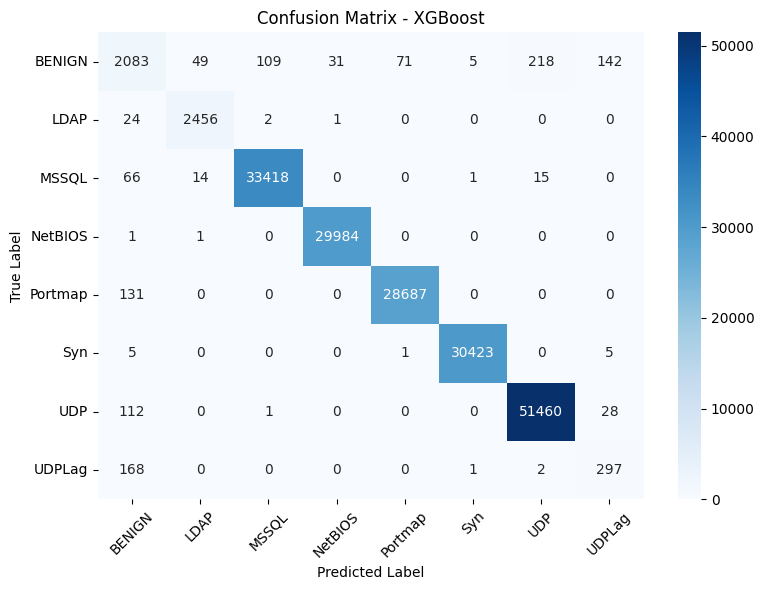


Training LightGBM ...
LightGBM Accuracy: 0.9547
Balanced Accuracy: 0.7387
Macro F1-score: 0.7483
Training Time: 422.94 seconds

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.37      0.37      0.37      2708
        LDAP       0.83      0.63      0.72      2483
       MSSQL       0.95      0.94      0.95     33514
     NetBIOS       0.96      0.97      0.96     29986
     Portmap       0.96      0.97      0.96     28818
         Syn       0.99      0.99      0.99     30434
         UDP       0.98      0.98      0.98     51601
      UDPLag       0.06      0.05      0.06       468

    accuracy                           0.95    180012
   macro avg       0.76      0.74      0.75    180012
weighted avg       0.95      0.95      0.95    180012



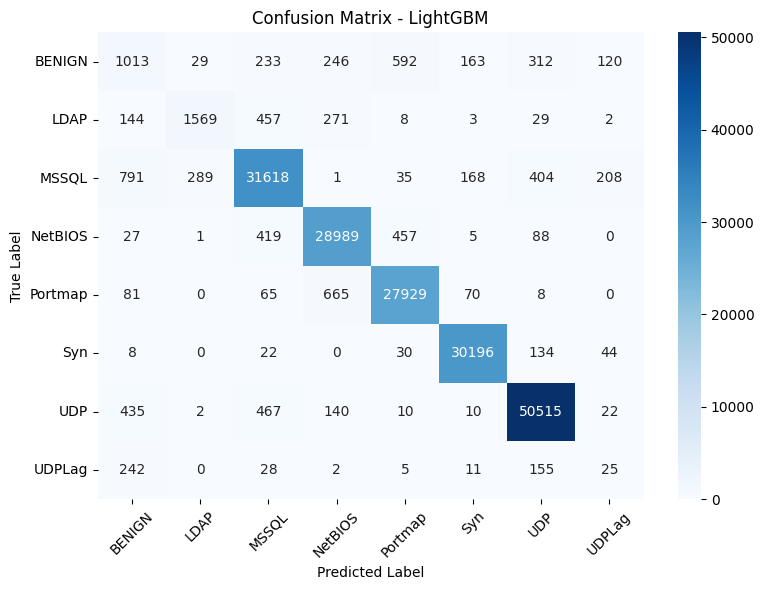

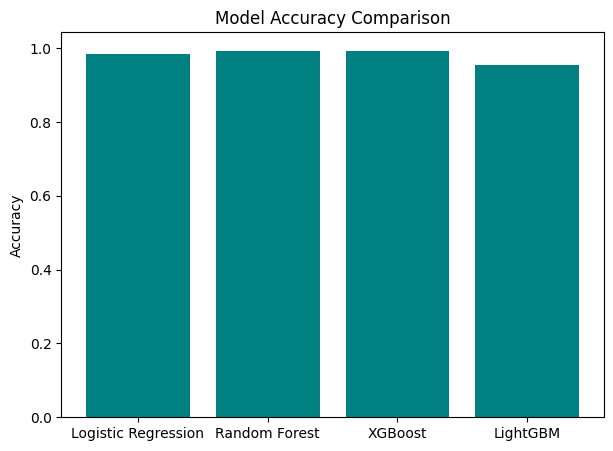

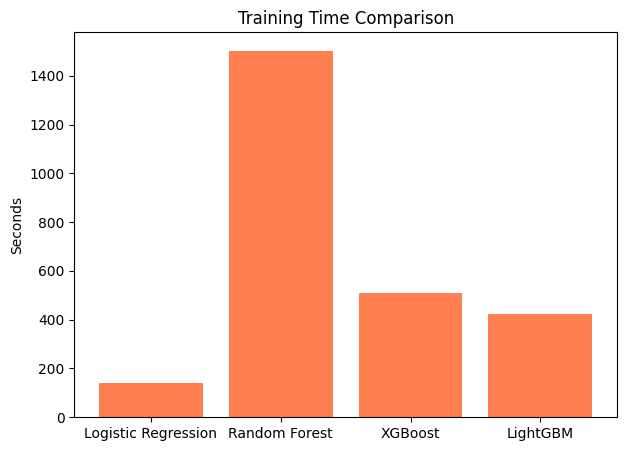


✅ Best Model: Random Forest (by Balanced Accuracy)


In [22]:
# =============================================
# ✅ Setup
# =============================================
import pandas as pd
import numpy as np
import time, os, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Suppress warnings and LightGBM messages
warnings.filterwarnings("ignore")
os.environ["LIGHTGBM_VERBOSITY"] = "-1"

# =============================================
# ✅ Mount Google Drive
# =============================================
from google.colab import drive
drive.mount('/content/drive')

# Path to your folder in Drive
folder_path = "/content/drive/MyDrive/CICDDoS2019"

# List CSVs
import glob
all_files = sorted(glob.glob(folder_path + "/*.csv"))
print(f"Found {len(all_files)} CSV files.")

# =============================================
# ✅ Load a small sample from each CSV
# =============================================
print("Loading data in chunks...")
train_files = all_files[:int(0.8 * len(all_files))]
test_files  = all_files[int(0.8 * len(all_files)):]

def load_data(file_list, nrows=120000):  # slightly more rows
    dataframes = []
    for file in file_list:
        print(f"Reading {file} ...")
        part = pd.read_csv(file, low_memory=False, nrows=nrows)
        dataframes.append(part)
    return pd.concat(dataframes, ignore_index=True)

print("Loading training and test data separately...")
train_df = load_data(train_files, nrows=120000)
test_df  = load_data(test_files, nrows=120000)

df = pd.concat([train_df, test_df], ignore_index=True)
print(f"Loaded total {len(df)} rows")

# =============================================
# ✅ Preprocessing
# =============================================
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna(axis=1, how='all')
df = df.loc[:, df.nunique() > 1]
df = df.dropna()

label_col = ' Label' if ' Label' in df.columns else 'Label'
y = df[label_col]
X = df.drop(columns=[label_col])

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Encode target labels
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Fix infinite/NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# =============================================
# ⚙️  Add difficulty improvements
# =============================================

# 1️⃣ Handle imbalance — downsample majority class
Xy = pd.concat([X, pd.Series(y, name='LabelEnc')], axis=1)

# Drop rows where LabelEnc might be NaN
Xy = Xy.dropna(subset=['LabelEnc'])

majority_class = Xy['LabelEnc'].value_counts().idxmax()
majority = Xy[Xy['LabelEnc'] == majority_class]
minorities = Xy[Xy['LabelEnc'] != majority_class]

majority_down = resample(
    majority,
    replace=False,
    n_samples=int(len(majority) * 0.5),  # downsample 50%
    random_state=42
)

df_balanced = pd.concat([majority_down, minorities]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['LabelEnc'])
y = df_balanced['LabelEnc']

# Ensure no NaNs in y
if y.isna().any():
    print("⚠️ Found NaNs in target, removing them...")
    valid_mask = ~y.isna()
    X = X.loc[valid_mask].reset_index(drop=True)
    y = y.loc[valid_mask].reset_index(drop=True)

# 2️⃣ Add small random noise to continuous features
numeric_cols = X.select_dtypes(include=[np.number]).columns
noise = np.random.normal(0, 0.01, X[numeric_cols].shape)
X[numeric_cols] = X[numeric_cols] + noise

# ✅ Reindex to be safe
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# =============================================
# ✅ Train/Test Split (before scaling)
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# =============================================
# ✅ Safe Scaling (after split)
# =============================================
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# =============================================
# ✅ Final Safety Cleaning before Training
# =============================================
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Replace inf/-inf (just in case)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaNs (shouldn't be any, but safe)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print("✅ Data cleaned: no NaNs or inf values remain.")


# =============================================
# ✅ Models
# =============================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbosity=0,
        tree_method='hist'
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
}

# =============================================
# ✅ Training and Evaluation
# =============================================
results = {}
plt.figure(figsize=(10, 6))

for name, model in models.items():
    print(f"\nTraining {name} ...")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    from sklearn.metrics import f1_score, balanced_accuracy_score
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_y.classes_))

    results[name] = {"acc": acc, "bal_acc": bal_acc, "f1": f1_macro, "time": train_time}

    # Confusion Matrix with class names
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le_y.classes_, yticklabels=le_y.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ROC Curve (binary only)
    try:
        y_score = model.predict_proba(X_test)
        if y_score.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC-AUC Curve - {name}")
            plt.legend()
            plt.show()
    except:
        pass

# =============================================
# ✅ Summary
# =============================================
plt.figure(figsize=(7, 5))
plt.bar(results.keys(), [r["acc"] for r in results.values()], color="teal")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(7, 5))
plt.bar(results.keys(), [r["time"] for r in results.values()], color="coral")
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.show()

# =============================================
# ✅ Best Model Selection
# =============================================
best_model_name = max(results, key=lambda x: results[x]['bal_acc'])
print(f"\n✅ Best Model: {best_model_name} (by Balanced Accuracy)")
